## Introduction

A while back I read [this interesting post](https://economicsfromthetopdown.com/2022/04/08/the-dunning-kruger-effect-is-autocorrelation/) that explained how the Dunning-Kruger effect is an example of autocorrelation. Before proceeding with the rest of this post, I'd highly recommend reading that one. I liked their example of using simulated data to show that the supposed effect can be observed even in completely uncorrelated variables. It got me wondering what it would look like if we had other relationships between predicted and actual performance, and so this post is an opportunity to explore that.

## Setup (all the code is here)

If you don't want to read code and just want to see the charts feel free to skip to the next section.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("dark_background")

In [2]:
N_SAMPLES = 1_000

In [3]:
class DunningKruger:
    def __init__(self, actual_dist: np.ndarray, predicted_dist: np.ndarray) -> None:
        """Build dataframe of actual percentile vs predicted."""
        self.df = (
            pd.DataFrame({"Actual Distribution": actual_dist, "Predicted Distribution":predicted_dist})
            # Handle prediction errors that produce impossible percentiles
            .clip(lower=0.0, upper=100.0)
            .assign(predict_error=lambda df: df["Predicted Distribution"] - df["Actual Distribution"])
            .rename(columns={"predict_error": "Prediction Error"})
        )
    
    @property
    def x_vs_y_chart(self) -> sns.axisgrid.FacetGrid:
        """Original style chart of actual vs predicted."""
        g = sns.lmplot(x="Actual Distribution", y="Predicted Distribution", data=self.df, scatter_kws={"alpha": 0.25})
        g.ax.axline((0,0), (100,100), linewidth=2, color="white", linestyle="--", alpha=0.5)
        plt.show()

    @property
    def x_vs_error_chart(self) -> sns.axisgrid.FacetGrid:
        """Actual vs prediction error (implicit reference in DK paper)."""
        g = sns.lmplot(x="Actual Distribution", y="Prediction Error", data=self.df, scatter_kws={"alpha": 0.25});
        g.ax.axline((0,0), (100,0), linewidth=2, color="white", linestyle="--", alpha=0.5)
        plt.show()

## Scenarios

In the following sections I'll simulate some actual vs predicted distributions and see what they look like when you compare them to the Dunning Kruger graph. I'm not going to plot quantile vs percentile as in the original chart, as I think that just obscures what's actually going on. The percentile vs percentile view shows the same overall pattern if you fit a regression line through it, which is easy enough to do.

### Purely random

This was the example in the original blog post that convinced me of the argument. I'll start by reproducing it here. In this example predicted percentile performance is completely random and independent of actual percentile.

In [4]:
actual_dist = np.random.uniform(low=0.0, high=100.0, size=N_SAMPLES)
predicted_dist = np.random.uniform(low=0.0, high=100.0, size=N_SAMPLES)

In [5]:
dk = DunningKruger(actual_dist, predicted_dist)

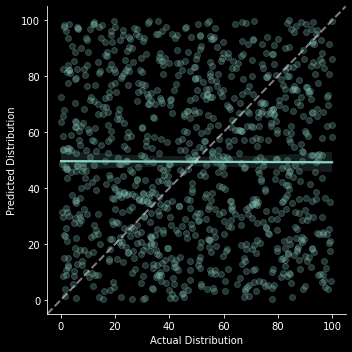

In [6]:
dk.x_vs_y_chart

The basic format of this ```x_vs_y_chart``` will be the same in all scenarios, so I'll just explain how to interpret it in this first example. The x axis represents someone's actual place in the percentile distribution, the y axis is their predicted place in that same distribution. Each point in the scatter plot represents a single observation of someone's actual place in the distribution and their corresponding prediction of where they are in the distribution. The white dotted line moving up at a 45 degree angle represents perfect prediction, where all observations would be if everyone could exactly predict their place in the distribution. The blue-green line is a regression line of the relationship between someone's actual place in the distribution and their prediction. The fact that it's pretty much flat suggests no relationship, which is what we'd expect since that's how the data was generated

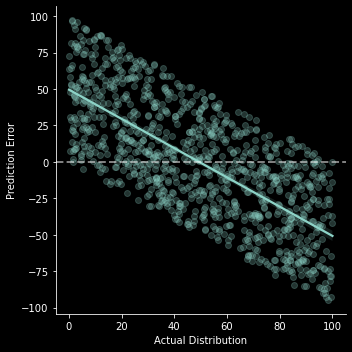

In [7]:
dk.x_vs_error_chart;

As with the previous chart, the basic format of this ```x_vs_error_chart``` will be the same in all scenarios, so I'll just explain how to interpret it in this first example. The x axis again represents someone's actual place in the percentile distribution, but now the y axis is the difference between their prediction and actual place. Each point in the scatter plot represents a single observation of someone's actual place in the distribution and their corresponding prediction error. The horizontal white dotted line moving up at a zero again represents perfect prediction, where all observations would be if everyone could exactly predict their place in the distribution. The blue-green line is a regression line of the relationship between someone's actual place in the distribution and their prediction error. Note that in this randomly generated scenario we're seeing something that looks like Dunning Kruger, with people on the low endof the distribution tending to overestimate their place, and people on the high end tending to underestimate.

### Unbiased prediction error

In this scenario everyone is equally good at predicting their percentile placement with only a small, unbiased error.

In [8]:
actual_dist = np.random.uniform(low=0.0, high=100.0, size=N_SAMPLES)
error = np.random.normal(loc=0.0, scale=10.0, size=N_SAMPLES)
predicted_dist = actual_dist + error

In [9]:
dk = DunningKruger(actual_dist, predicted_dist)

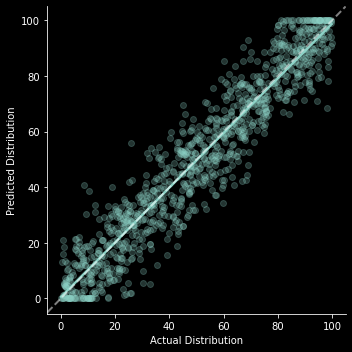

In [10]:
dk.x_vs_y_chart;

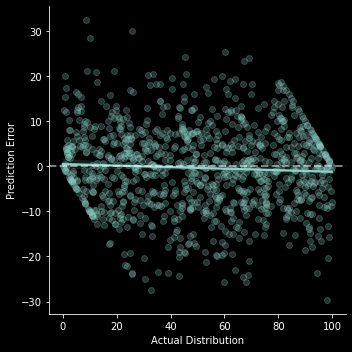

In [11]:
dk.x_vs_error_chart;

Even here we can see a slight appearance of "overconfidence" for lower percentiles and "underconfidence" for higher percentiles simply because prediction errors are truncated at the top and bottom (If I'm actually in the lowest percentile the only errors I can possibly make are to overestimate my performance).

### Actual Dunning Kruger

Let's see what this would actually look like if we simply had overconfidence in the bottom half of the distribution. I could add in underconfidence among the top half as well, but the message of the original paper focused on the overconfidence so let's do the same here.

In [12]:
actual_dist = np.random.uniform(low=0.0, high=100.0, size=N_SAMPLES)
base_error = np.random.normal(loc=0.0, scale=10.0, size=N_SAMPLES)
below_median_indicator = actual_dist < 50.0
# The further below the median you are the greater you might overestimate your position
error_scaler = (50.0 - actual_dist) * below_median_indicator
# Scale up how overconfident this makes you
overconfidence_error = error_scaler * np.random.uniform(low=0.0, high=2.0, size=N_SAMPLES)
predicted_dist = actual_dist + error + overconfidence_error

In [13]:
dk = DunningKruger(actual_dist, predicted_dist)

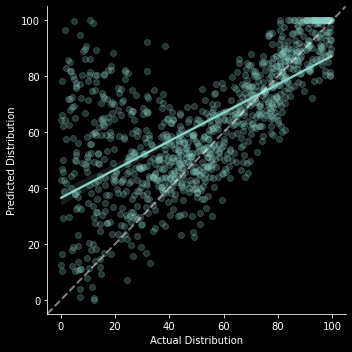

In [14]:
dk.x_vs_y_chart;

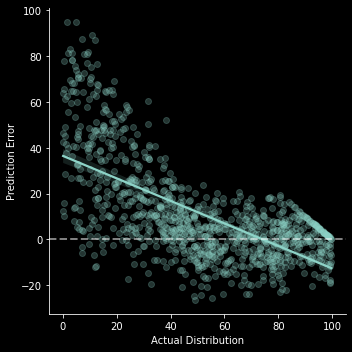

In [15]:
dk.x_vs_error_chart;

## Conclusion

Honestly I was pretty convinced by the argument in the original post, so nothing earth shattering came out of this exercise for me. But it was interesting to see what the charts looked like under different situations. And it gave me an excuse to write some code and build some charts, which I haven't had in a while.

If you'd like to try out other scenarios, you can click the binder link near the top of this post to open it in an interactive notebook. If you want to try other distributions for your actual/predicted/error distributions, check out the [numpy docs](https://numpy.org/doc/stable/reference/random/) on random sampling.